## Initialization

## Load Data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True,
                                   fill_mode = "nearest", zoom_range = 0.2,
                                   width_shift_range = 0.2, height_shift_range=0.2,
                                   rotation_range=30) 

train_generator = train_datagen.flow_from_dataframe(dataframe=labels, directory='/datasets/faces/final_files/', 
                                              x_col="file_name", y_col="real_age", 
                                              class_mode="raw", target_size=(224, 224), 
                                              batch_size=32, seed = 1337)

Found 7591 validated image filenames.


In [4]:
pic_array = []
for filename in glob.glob('/datasets/faces/final_files/*.jpg'):
    pic = Image.open(filename)
    pic_array.append(pic)

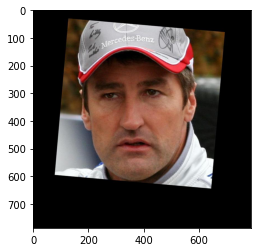

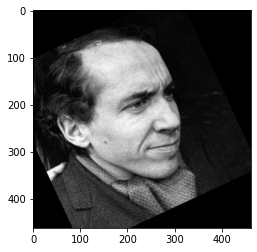

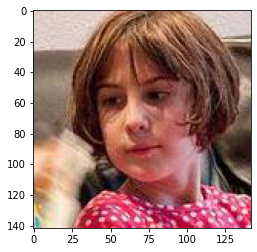

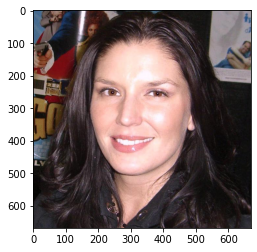

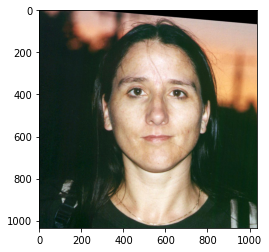

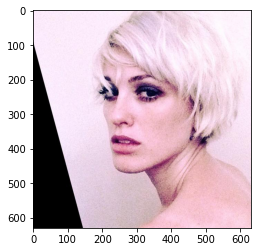

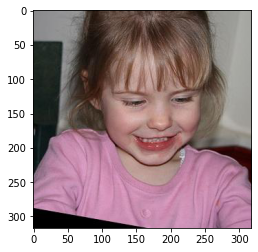

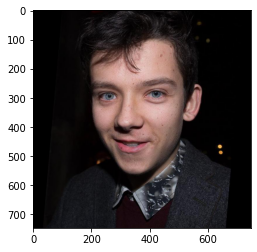

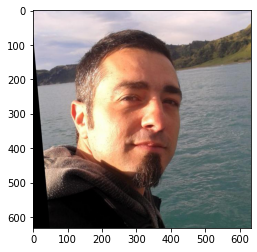

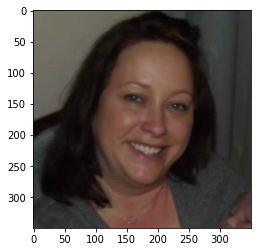

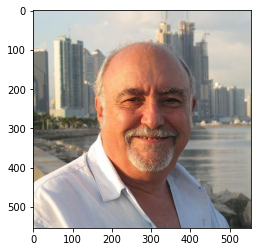

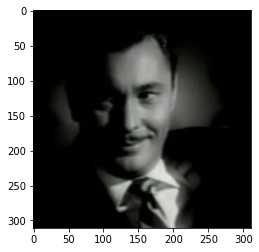

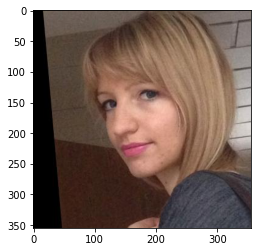

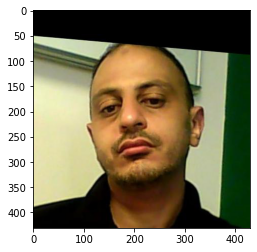

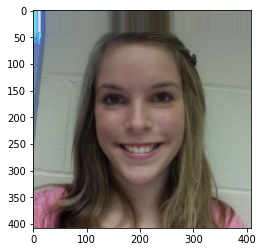

In [5]:
for i in range(0,15):    
    plt.imshow(np.array(pic_array[i]))
    plt.show()

The dataset has pictures of faces from different angles, but they are all straightened to be vertical.

## EDA

array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

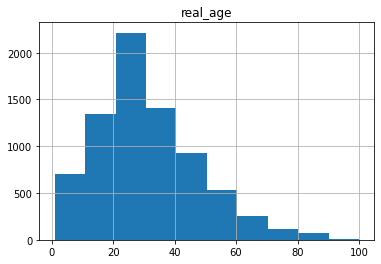

In [6]:
labels.hist()

### Findings

Having the majority of ages be in a specific range will probably make the model be better at recognizing ages in that same range. Using a neural network will mitigate this issue.

## Modelling

Training is done on the courses paltforms GPU- Functions are defined with set names for it to recognize them.

In [7]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [8]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True,
                                       fill_mode = "nearest", zoom_range = 0.2,
                                       width_shift_range = 0.2, height_shift_range=0.2,
                                       rotation_range=30, validation_split = 0.25) 

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels, directory='/datasets/faces/final_files/', 
                                                  x_col="file_name", y_col="real_age", 
                                                  class_mode="raw", target_size=(224, 224), 
                                                  batch_size=32, subset='training', seed = 1337)
     
    return train_datagen_flow

In [9]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    labels = pd.read_csv('/datasets/faces/labels.csv')
    test_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.25) 

    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels, directory='/datasets/faces/final_files/', 
                                                  x_col="file_name", y_col="real_age", 
                                                  class_mode="raw", target_size=(224, 224), 
                                                  batch_size=32, subset='validation', seed = 1337)
    return test_datagen_flow

In [10]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    backbone = ResNet50(
        input_shape=(224, 224, 3), weights='imagenet', include_top=False
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation='relu')) 

    optimizer = Adam(lr=0.00001)
    model.compile(optimizer=optimizer, loss='mae',
                  metrics=['mae'])

    return model

In [11]:
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
    )

    return model

### Output

Output from GPU training.

    Found 5694 validated image filenames.
    Found 1897 validated image filenames.

        8192/94765736 [..............................] - ETA: 1s
    10051584/94765736 [==>...........................] - ETA: 0s
    19136512/94765736 [=====>........................] - ETA: 0s
    30752768/94765736 [========>.....................] - ETA: 0s
    42442752/94765736 [============>.................] - ETA: 0s
    54140928/94765736 [================>.............] - ETA: 0s
    65732608/94765736 [===================>..........] - ETA: 0s
    77422592/94765736 [=======================>......] - ETA: 0s
    89055232/94765736 [===========================>..] - ETA: 0s
    94773248/94765736 [==============================] - 0s 0us/step
    <class 'tensorflow.python.keras.engine.sequential.Sequential'>
    WARNING:tensorflow:sample_weight modes were coerced from
      ...
        to  
      ['...']
    WARNING:tensorflow:sample_weight modes were coerced from
      ...
        to  
      ['...']
    Train for 178 steps, validate for 60 steps
    Epoch 1/20
    178/178 - 103s - loss: 28.2758 - mae: 28.2777 - val_loss: 29.1440 - val_mae: 29.0356
    Epoch 2/20
    178/178 - 94s - loss: 18.5338 - mae: 18.5363 - val_loss: 29.4821 - val_mae: 29.3736
    Epoch 3/20
    178/178 - 94s - loss: 13.6300 - mae: 13.6319 - val_loss: 29.5043 - val_mae: 29.3954
    Epoch 4/20
    178/178 - 94s - loss: 10.9856 - mae: 10.9873 - val_loss: 20.0262 - val_mae: 19.9342
    Epoch 5/20
    178/178 - 94s - loss: 9.3592 - mae: 9.3605 - val_loss: 8.6991 - val_mae: 8.6759
    Epoch 6/20
    178/178 - 94s - loss: 8.3915 - mae: 8.3926 - val_loss: 7.7023 - val_mae: 7.6842
    Epoch 7/20
    178/178 - 93s - loss: 7.9678 - mae: 7.9686 - val_loss: 8.5851 - val_mae: 8.5549
    Epoch 8/20
    178/178 - 93s - loss: 7.5353 - mae: 7.5358 - val_loss: 7.6031 - val_mae: 7.5857
    Epoch 9/20
    178/178 - 93s - loss: 7.3376 - mae: 7.3380 - val_loss: 7.2444 - val_mae: 7.2292
    Epoch 10/20
    178/178 - 93s - loss: 7.0964 - mae: 7.0967 - val_loss: 6.6795 - val_mae: 6.6718
    Epoch 11/20
    178/178 - 93s - loss: 6.7588 - mae: 6.7590 - val_loss: 7.2535 - val_mae: 7.2393
    Epoch 12/20
    178/178 - 93s - loss: 6.5895 - mae: 6.5896 - val_loss: 6.7769 - val_mae: 6.7824
    Epoch 13/20
    178/178 - 93s - loss: 6.4668 - mae: 6.4666 - val_loss: 6.7328 - val_mae: 6.7333
    Epoch 14/20
    178/178 - 93s - loss: 6.3125 - mae: 6.3125 - val_loss: 6.3470 - val_mae: 6.3560
    Epoch 15/20
    178/178 - 93s - loss: 6.1413 - mae: 6.1411 - val_loss: 6.3776 - val_mae: 6.3875
    Epoch 16/20
    178/178 - 94s - loss: 6.0026 - mae: 6.0025 - val_loss: 6.3504 - val_mae: 6.3542
    Epoch 17/20
    178/178 - 93s - loss: 5.9743 - mae: 5.9744 - val_loss: 6.2851 - val_mae: 6.2800
    Epoch 18/20
    178/178 - 93s - loss: 5.8701 - mae: 5.8699 - val_loss: 6.2285 - val_mae: 6.2155
    Epoch 19/20
    178/178 - 93s - loss: 5.7286 - mae: 5.7283 - val_loss: 6.4688 - val_mae: 6.4748
    Epoch 20/20
    178/178 - 94s - loss: 5.6744 - mae: 5.6738 - val_loss: 6.2956 - val_mae: 6.2784
    WARNING:tensorflow:sample_weight modes were coerced from
      ...
        to  
      ['...']
    60/60 - 10s - loss: 6.2956 - mae: 6.2784
    Test MAE: 6.2784

## Conclusions

Using ResNet50 as a backbone, with very few additional changes, gives decent results. Of course, giving the model more epochs to run tightens the predictions. 

Seeing as the shops are fitted with their own cameras, we can assume additional data will be pretty uniform and results may improve substentialy over time.

As of now, MAE is not low enough to make sure nobody underage gets their hands on an alcoholic drink- the error margin is problematic for such a stern distinction at a very specific age.

What the system can be useful for, is producing product recommendations for the customer based on age. Ages can be put into wider categories, and then the error is more acceptable.